# Imports & Configuration

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    mean_squared_error, r2_score
)

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    ExtraTreesRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Unsupervised
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Explainability
import shap

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


# Data Loading & Raw Inspection

In [2]:

df = pd.read_csv("FY_2025_Hospital_Readmissions_Reduction_Program_Hospital.csv")

df.head()
df.shape
df.info()
df.isnull().mean().sort_values(ascending=False)
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18510 entries, 0 to 18509
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Facility Name               18510 non-null  object 
 1   Facility ID                 18510 non-null  int64  
 2   State                       18510 non-null  object 
 3   Measure Name                18510 non-null  object 
 4   Number of Discharges        8340 non-null   float64
 5   Footnote                    6583 non-null   float64
 6   Excess Readmission Ratio    11927 non-null  float64
 7   Predicted Readmission Rate  11927 non-null  float64
 8   Expected Readmission Rate   11927 non-null  float64
 9   Number of Readmissions      11927 non-null  object 
 10  Start Date                  18510 non-null  object 
 11  End Date                    18510 non-null  object 
dtypes: float64(5), int64(1), object(6)
memory usage: 1.7+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Facility Name,18510,3021,MEMORIAL HOSPITAL,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Facility ID,18510.0,NaN,NaN,NaN,261770.055105,164647.739172,10001.0,110073.0,250048.0,390133.0,670327.0
State,18510,51,TX,1704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Measure Name,18510,6,READM-30-AMI-HRRP,3085,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number of Discharges,8340.0,NaN,NaN,NaN,279.269904,266.018069,0.0,115.0,197.0,354.0,4501.0
Footnote,6583.0,NaN,NaN,NaN,3.187756,2.089167,1.0,1.0,5.0,5.0,7.0
Excess Readmission Ratio,11927.0,NaN,NaN,NaN,1.001719,0.080547,0.4779,0.95655,0.9982,1.043,1.643
Predicted Readmission Rate,11927.0,NaN,NaN,NaN,14.995386,5.017854,1.6742,12.533,16.0602,18.609,27.8095
Expected Readmission Rate,11927.0,NaN,NaN,NaN,14.961234,4.871997,2.8921,12.6128,16.146,18.66735,25.3942
Number of Readmissions,11927,285,Too Few to Report,3806,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning & Preprocessing (Transparent)

In [3]:

df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

# Preserve raw issue demonstration
df = df.replace("N/A", np.nan)

df = df.drop(columns=["footnote"])
df = df.dropna(subset=["excess_readmission_ratio"])

df["number_of_readmissions"] = pd.to_numeric(
    df["number_of_readmissions"], errors="coerce"
)

df["low_volume_flag"] = df["number_of_readmissions"].isna().astype(int)

num_cols = [
    "number_of_discharges",
    "predicted_readmission_rate",
    "expected_readmission_rate"
]

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])

df["measurement_period_years"] = (
    df["end_date"] - df["start_date"]
).dt.days / 365

df["high_readmission_risk"] = (
    df["excess_readmission_ratio"] > 1.0
).astype(int)

df.isnull().sum().sum()


3806

In [4]:

df.describe(include="all").T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
facility_name,11927,2800,ST JOSEPH MEDICAL CENTER,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
facility_id,11927.0,NaN,NaN,NaN,257437.727006,10001.0,110043.5,250019.0,390041.0,670309.0,157717.512144
state,11927,51,CA,1024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
measure_name,11927,6,READM-30-PN-HRRP,2731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_of_discharges,11927.0,NaN,NaN,NaN,260.059445,25.0,153.5,203.0,269.0,4501.0,222.568021
excess_readmission_ratio,11927.0,NaN,NaN,NaN,1.001719,0.4779,0.95655,0.9982,1.043,1.643,0.080547
predicted_readmission_rate,11927.0,NaN,NaN,NaN,14.995386,1.6742,12.533,16.0602,18.609,27.8095,5.017854
expected_readmission_rate,11927.0,NaN,NaN,NaN,14.961234,2.8921,12.6128,16.146,18.66735,25.3942,4.871997
number_of_readmissions,8121.0,NaN,NaN,NaN,48.074868,11.0,19.0,31.0,59.0,877.0,48.488707
start_date,11927,NaN,NaN,NaN,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,2020-07-01 00:00:00,NaN


In [5]:

df.info()
df.isnull().mean().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
Index: 11927 entries, 0 to 18464
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   facility_name               11927 non-null  object        
 1   facility_id                 11927 non-null  int64         
 2   state                       11927 non-null  object        
 3   measure_name                11927 non-null  object        
 4   number_of_discharges        11927 non-null  float64       
 5   excess_readmission_ratio    11927 non-null  float64       
 6   predicted_readmission_rate  11927 non-null  float64       
 7   expected_readmission_rate   11927 non-null  float64       
 8   number_of_readmissions      8121 non-null   float64       
 9   start_date                  11927 non-null  datetime64[ns]
 10  end_date                    11927 non-null  datetime64[ns]
 11  low_volume_flag             11927 non-null  int32         


number_of_readmissions        0.319108
facility_name                 0.000000
facility_id                   0.000000
state                         0.000000
measure_name                  0.000000
number_of_discharges          0.000000
excess_readmission_ratio      0.000000
predicted_readmission_rate    0.000000
expected_readmission_rate     0.000000
start_date                    0.000000
end_date                      0.000000
low_volume_flag               0.000000
measurement_period_years      0.000000
high_readmission_risk         0.000000
dtype: float64

# Exploratory Data Analysis (EDA)

In [6]:

df["number_of_readmissions"].describe()

count    8121.000000
mean       48.074868
std        48.488707
min        11.000000
25%        19.000000
50%        31.000000
75%        59.000000
max       877.000000
Name: number_of_readmissions, dtype: float64

In [7]:

df["number_of_readmissions"].isna().mean()

0.3191079064307873

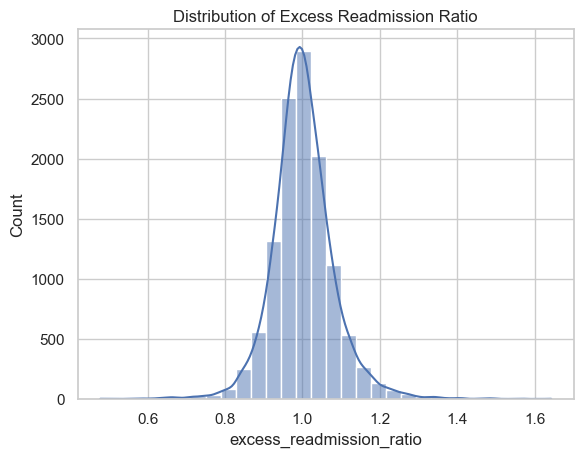

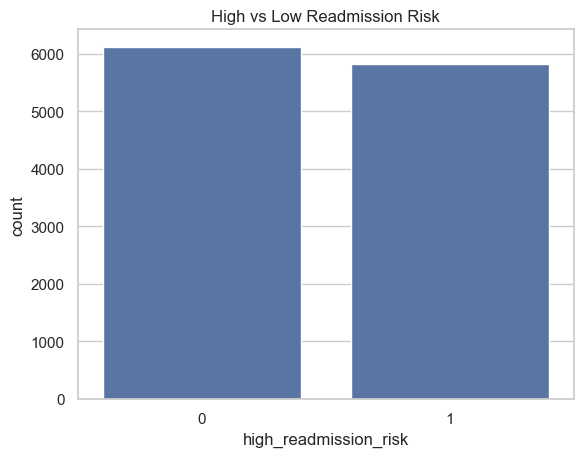

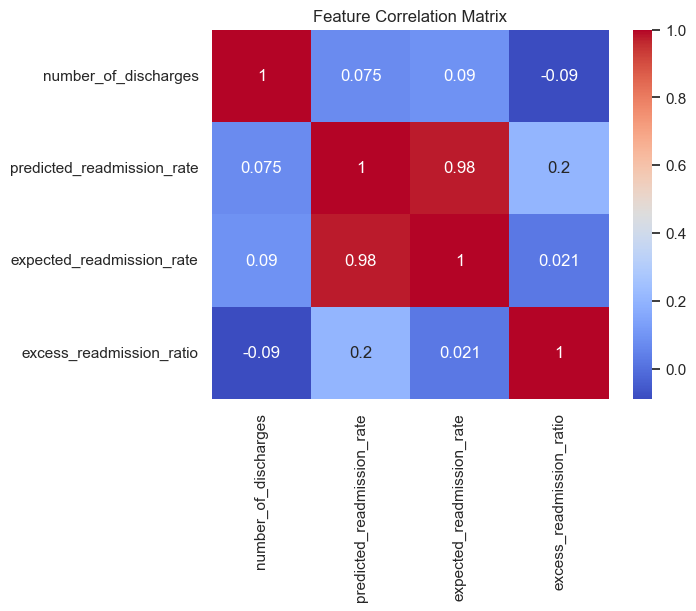

state
MA    1.040929
NJ    1.027824
IL    1.020149
DC    1.019689
FL    1.019341
NV    1.018937
WV    1.015663
VT    1.011689
KY    1.010749
CA    1.010414
Name: excess_readmission_ratio, dtype: float64

In [8]:

sns.histplot(df["excess_readmission_ratio"], bins=30, kde=True)
plt.title("Distribution of Excess Readmission Ratio")
plt.show()

sns.countplot(x="high_readmission_risk", data=df)
plt.title("High vs Low Readmission Risk")
plt.show()

sns.heatmap(
    df[num_cols + ["excess_readmission_ratio"]].corr(),
    annot=True, cmap="coolwarm"
)
plt.title("Feature Correlation Matrix")
plt.show()

df.groupby("state")["excess_readmission_ratio"].mean().sort_values(ascending=False).head(10)


# Feature Engineering

In [9]:

le = LabelEncoder()
df["state_encoded"] = le.fit_transform(df["state"])
df["measure_encoded"] = le.fit_transform(df["measure_name"])

features = [
    "number_of_discharges",
    "predicted_readmission_rate",
    "expected_readmission_rate",
    "measurement_period_years",
    "low_volume_flag",
    "state_encoded",
    "measure_encoded"
]

X = df[features]
y_reg = df["excess_readmission_ratio"]
y_clf = df["high_readmission_risk"]

X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

_, _, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42
)


# Regression Models (10 Algorithms)

In [10]:

reg_models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=200),
    "Extra Trees": ExtraTreesRegressor(n_estimators=200),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "SVR": SVR()
}

results_reg = []

for name, model in reg_models.items():
    model.fit(X_train, y_train_reg)
    preds = model.predict(X_test)

    results_reg.append({
        "Model": name,
        "RMSE": mean_squared_error(y_test_reg, preds, squared=False),
        "R2": r2_score(y_test_reg, preds)
    })

reg_results_df = pd.DataFrame(results_reg)
reg_results_df


,Model,RMSE,R2
0,Linear,0.037877,0.771167
1,Ridge,0.037878,0.771166
2,Lasso,0.078988,0.004879
3,ElasticNet,0.078905,0.006967
4,Decision Tree,0.014081,0.968374
5,Random Forest,0.008451,0.988608
6,Extra Trees,0.007767,0.990378
7,Gradient Boosting,0.028555,0.869945
8,AdaBoost,0.065194,0.322095
9,SVR,0.069073,0.239015


## Regression Results Table
### Comparative Performance of Regression Models for Excess Readmission Ratio Prediction

In [11]:

reg_results_df.round(4)

,Model,RMSE,R2
0,Linear,0.0379,0.7712
1,Ridge,0.0379,0.7712
2,Lasso,0.0790,0.0049
3,ElasticNet,0.0789,0.0070
4,Decision Tree,0.0141,0.9684
5,Random Forest,0.0085,0.9886
6,Extra Trees,0.0078,0.9904
7,Gradient Boosting,0.0286,0.8699
8,AdaBoost,0.0652,0.3221
9,SVR,0.0691,0.2390


# Regression Cross-Validation

In [12]:

cv_reg = []

for name, model in reg_models.items():
    cv_rmse = -cross_val_score(
        model,
        X_train,
        y_train_reg,
        cv=5,
        scoring="neg_root_mean_squared_error"
    )
    cv_reg.append({
        "Model": name,
        "CV_RMSE_Mean": cv_rmse.mean(),
        "CV_RMSE_Std": cv_rmse.std()
    })

cv_reg_df = pd.DataFrame(cv_reg)
cv_reg_df


,Model,CV_RMSE_Mean,CV_RMSE_Std
0,Linear,0.038357,0.001162
1,Ridge,0.038357,0.001163
2,Lasso,0.080708,0.000562
3,ElasticNet,0.080615,0.000472
4,Decision Tree,0.018627,0.001170
5,Random Forest,0.011223,0.001008
6,Extra Trees,0.010583,0.001338
7,Gradient Boosting,0.029793,0.001055
8,AdaBoost,0.064359,0.000981
9,SVR,0.072109,0.000547


## Regression Cross-Validation Table
### Cross-Validated RMSE Scores of Regression Models (5-Fold CV)

In [13]:

cv_reg_df.round(4)

,Model,CV_RMSE_Mean,CV_RMSE_Std
0,Linear,0.0384,0.0012
1,Ridge,0.0384,0.0012
2,Lasso,0.0807,0.0006
3,ElasticNet,0.0806,0.0005
4,Decision Tree,0.0186,0.0012
5,Random Forest,0.0112,0.0010
6,Extra Trees,0.0106,0.0013
7,Gradient Boosting,0.0298,0.0011
8,AdaBoost,0.0644,0.0010
9,SVR,0.0721,0.0005


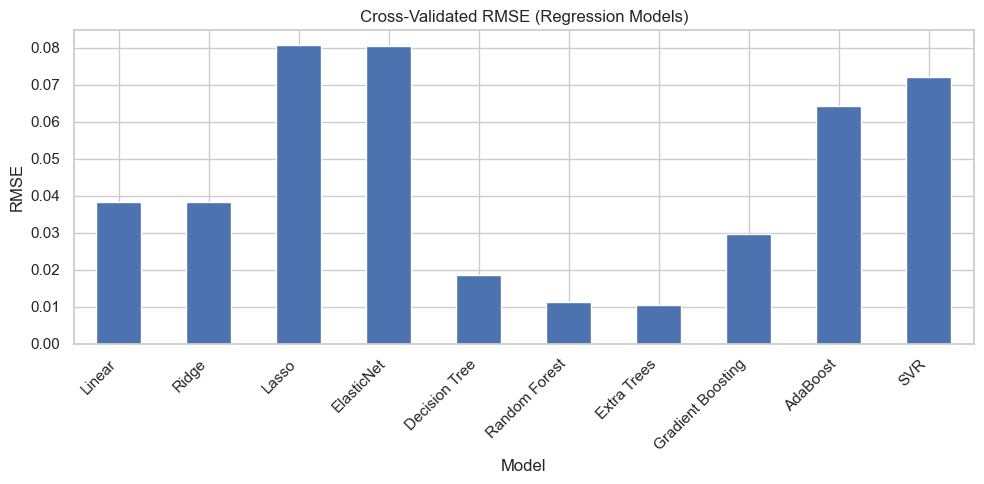

In [14]:

ax = cv_reg_df.set_index("Model")[["CV_RMSE_Mean"]].plot(
    kind="bar",
    figsize=(10, 5),
    legend=False
)

ax.set_title("Cross-Validated RMSE (Regression Models)")
ax.set_ylabel("RMSE")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Classification Models (8 Algorithms)

In [15]:

clf_models = {
    "Logistic": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=1000))
    ]),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "Extra Trees": ExtraTreesClassifier(n_estimators=200),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier())
    ]),
    "Naive Bayes": GaussianNB(),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(probability=True))
    ])
}

results_clf = []

for name, model in clf_models.items():
    model.fit(X_train, y_train_clf)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    results_clf.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test_clf, preds),
        "F1": f1_score(y_test_clf, preds),
        "ROC_AUC": roc_auc_score(y_test_clf, probs)
    })

clf_results_df = pd.DataFrame(results_clf)
clf_results_df


,Model,Accuracy,F1,ROC_AUC
0,Logistic,0.986169,0.985571,0.999509
1,Decision Tree,0.968986,0.967965,0.969036
2,Random Forest,0.930847,0.927409,0.981989
3,Extra Trees,0.917854,0.913732,0.973780
4,Gradient Boosting,0.940067,0.936585,0.989436
5,AdaBoost,0.818525,0.790315,0.916426
6,KNN,0.821459,0.811170,0.897270
7,Naive Bayes,0.611903,0.628112,0.640316
8,SVM,0.941744,0.938359,0.989678


## Classification Results Table
### Classification Performance for High Readmission Risk Prediction

In [16]:

clf_results_df.round(4)

,Model,Accuracy,F1,ROC_AUC
0,Logistic,0.9862,0.9856,0.9995
1,Decision Tree,0.9690,0.9680,0.9690
2,Random Forest,0.9308,0.9274,0.9820
3,Extra Trees,0.9179,0.9137,0.9738
4,Gradient Boosting,0.9401,0.9366,0.9894
5,AdaBoost,0.8185,0.7903,0.9164
6,KNN,0.8215,0.8112,0.8973
7,Naive Bayes,0.6119,0.6281,0.6403
8,SVM,0.9417,0.9384,0.9897


# Classification Cross-Validation (ROC-AUC)

In [17]:

cv_clf = []

for name, model in clf_models.items():
    cv_auc = cross_val_score(
        model,
        X_train,
        y_train_clf,
        cv=5,
        scoring="roc_auc"
    )
    cv_clf.append({
        "Model": name,
        "CV_ROC_AUC_Mean": cv_auc.mean(),
        "CV_ROC_AUC_Std": cv_auc.std()
    })

cv_clf_df = pd.DataFrame(cv_clf)
cv_clf_df


,Model,CV_ROC_AUC_Mean,CV_ROC_AUC_Std
0,Logistic,0.999483,0.000256
1,Decision Tree,0.965045,0.002749
2,Random Forest,0.984089,0.002759
3,Extra Trees,0.976444,0.002730
4,Gradient Boosting,0.988059,0.001248
5,AdaBoost,0.920117,0.003704
6,KNN,0.891432,0.008860
7,Naive Bayes,0.645837,0.015506
8,SVM,0.988503,0.001664


## Classification Cross-Validation Table
### Cross-Validated ROC-AUC Scores for Classification Models

In [18]:

cv_clf_df.round(4)

,Model,CV_ROC_AUC_Mean,CV_ROC_AUC_Std
0,Logistic,0.9995,0.0003
1,Decision Tree,0.9650,0.0027
2,Random Forest,0.9841,0.0028
3,Extra Trees,0.9764,0.0027
4,Gradient Boosting,0.9881,0.0012
5,AdaBoost,0.9201,0.0037
6,KNN,0.8914,0.0089
7,Naive Bayes,0.6458,0.0155
8,SVM,0.9885,0.0017


## Model Performance Comparison

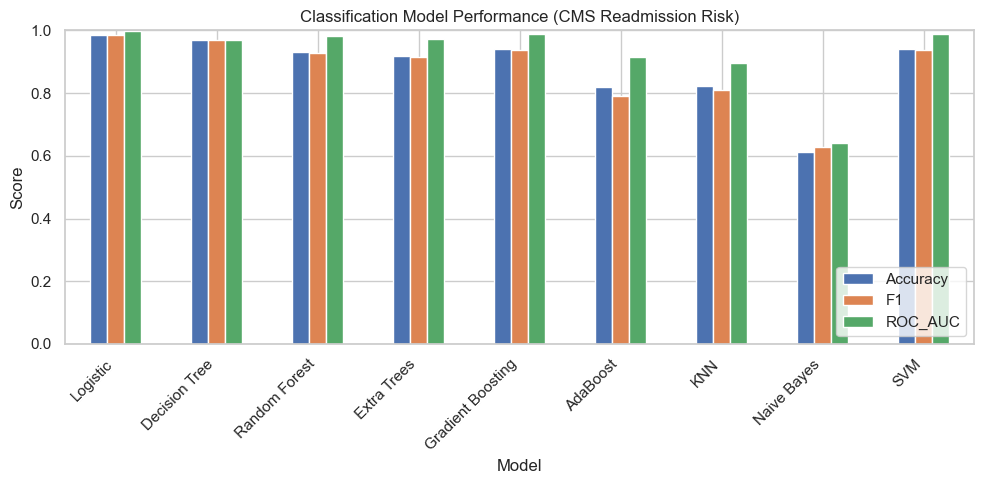

In [19]:

results_clf_df = pd.DataFrame(results_clf)

ax = results_clf_df.set_index("Model")[["Accuracy", "F1", "ROC_AUC"]].plot(
    kind="bar",
    figsize=(10, 5)
)

ax.set_title("Classification Model Performance (CMS Readmission Risk)")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.legend(loc="lower right")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Confusion Matrix

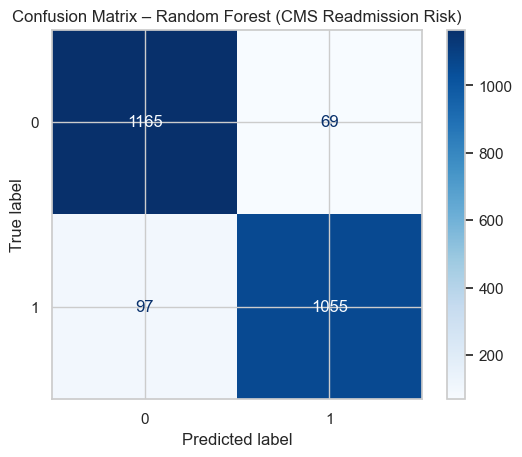

In [20]:

from sklearn.metrics import ConfusionMatrixDisplay
best_model = RandomForestClassifier(n_estimators=200, random_state=42)
best_model.fit(X_train, y_train_clf)
ConfusionMatrixDisplay.from_estimator(
    best_model, X_test, y_test_clf,  cmap="Blues"
)
plt.title("Confusion Matrix – Random Forest (CMS Readmission Risk)")
plt.show()

## OC Curves (Top 3 Models)

<Figure size 700x600 with 0 Axes>

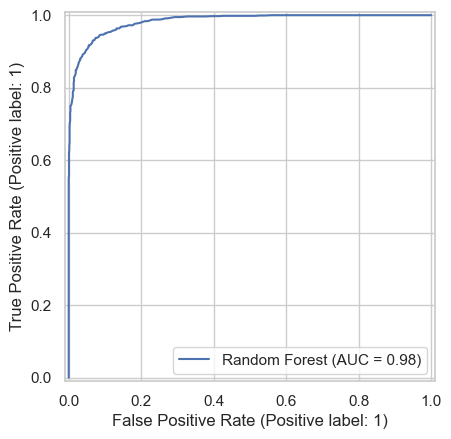

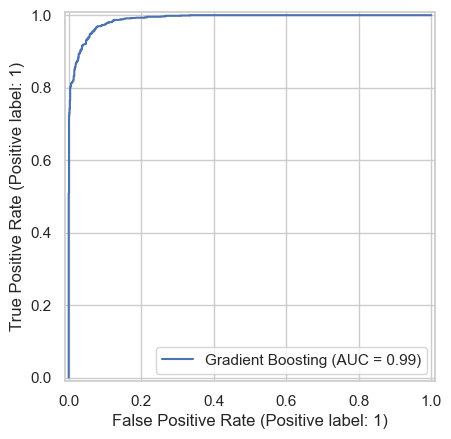

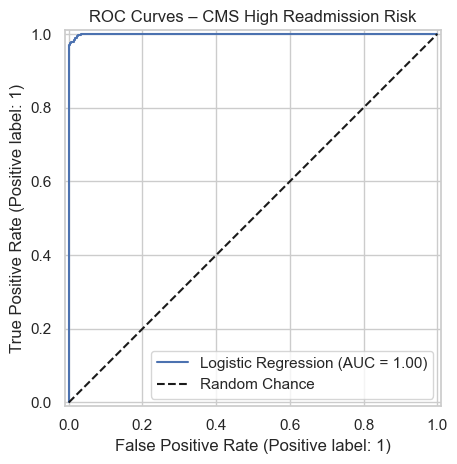

In [21]:

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train_clf)

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train_clf)

log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])
log_reg.fit(X_train, y_train_clf)


top_models = [
    ("Random Forest", rf),
    ("Gradient Boosting", gb),
    ("Logistic Regression", log_reg)
]

from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))

for name, model in top_models:
    RocCurveDisplay.from_estimator(
        model,
        X_test,
        y_test_clf,
        name=name
    )

plt.plot([0, 1], [0, 1], "k--", label="Random Chance")
plt.title("ROC Curves – CMS High Readmission Risk")
plt.legend()
plt.tight_layout()
plt.show()


# Unsupervised Learning (Validation)

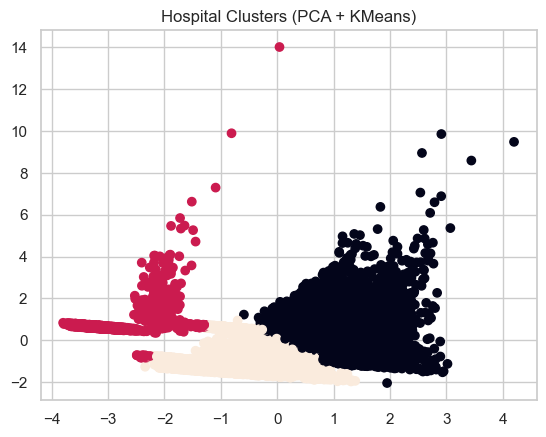

In [22]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
plt.title("Hospital Clusters (PCA + KMeans)")
plt.show()


# SHAP Explainability (Healthcare Transparency)

## Best Interpretable Model
### Random Forest

In [23]:

best_model = RandomForestClassifier(n_estimators=200, random_state=42)
best_model.fit(X_train, y_train_clf)

RandomForestClassifier(n_estimators=200, random_state=42)

## SHAP Tree Explainer

In [24]:

#explainer = shap.TreeExplainer(best_model)
#shap_values = explainer.shap_values(X_train)
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train)

100%|===================| 19080/19082 [29:55<00:00]        

## Global Feature Importance

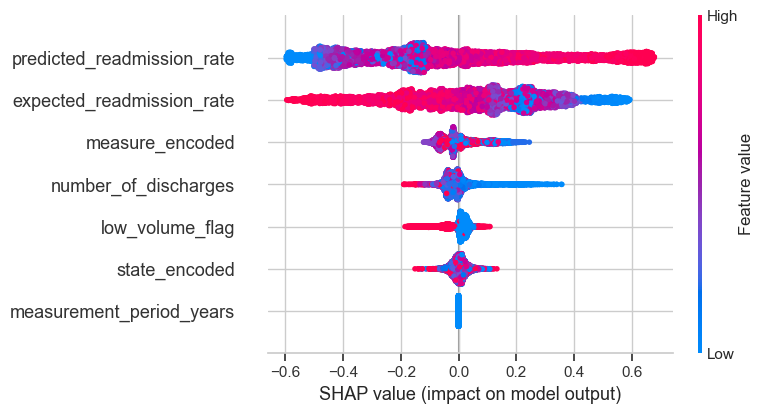

In [25]:

shap.summary_plot(
    shap_values.values[..., 1],  # positive class
    X_train,
    feature_names=features
)

In [26]:
import joblib
import os
import sklearn

print("Sklearn version:", sklearn.__version__)

os.makedirs("model", exist_ok=True)

joblib.dump(best_model, "model/best_model.pkl", compress=3)
joblib.dump(X_train.columns.tolist(), "model/features.pkl")

print("Model and features saved successfully")

Sklearn version: 1.5.1
Model and features saved successfully
